# Decision Trees, Random Forests & Support Vector Machines

[LendingClub](https://www.lendingclub.com/) is a US peer-to-peer lending company that operates an online lending platform. It was founded in 2006 and is headquartered in San Francisco, California. The platform facilitates the borrowing and lending of money directly between individuals, bypassing traditional banks. Investors can construct their portfolio of loans, according to their risk appetite. Naturally, if the borrower fails to repay their loan, investors lose money. Therefore, investors face the problem of predicting the risk of a borrower being unable to repay a loan.

The firm makes loan-level data freely available online so that investors can make informed decisions about whether to invest. Let's try and use ML models learned in class to predict whether a loan will be fully-paid or not, based on borrower characteristics. The data is available on the firms' webpage but here we will work with a dataset available on Kaggle.

Note that the original dataset has millions of loans. To keep things simple (and avoid computational bottlenecks) we will work with a random sample of this larger dataframe. Download two excel files from Moodle 'loan_data.xlsx' and 'descriptives.xlsx' and load them to your working environment. 

### Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import RandomizedSearchCV

# Load the CSV file into a Pandas DataFrame
# Load data from the first sheet
df = pd.read_excel('loan_data.xlsx')
desc = pd.read_excel('descriptives.xlsx')

# Display the DataFrame
df.head()

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


In [2]:
# print descriptives of the variables
desc

,credit.policy,"if the customer meets the credit underwriting criteria of LendingClub.com, and 0 otherwise."
0,purpose,"The purpose of the loan (takes values ""credit_..."
1,int.rate,"The purpose of the loan (takes values ""credit_..."
2,installment,"The purpose of the loan (takes values ""credit_..."
3,log.annual.inc,The natural log of the self-reported annual in...
4,dti,The debt-to-income ratio of the borrower (amou...
5,fico,The FICO credit score of the borrower.
6,days.with.cr.line,The number of days the borrower has had a cred...
7,revol.bal,The borrower's revolving balance (amount unpai...
8,revol.util,The borrower's revolving balance (amount unpai...
9,inq.last.6mths,The borrower's number of inquiries by creditor...


### Data Descriptives

To have a feel for the data it's always a good idea to start with simple descriptive statistics. Because our focus is on classification (ie. predict delinquencies), let's also plot some descriptives for loans that have and have not been fully paid. 

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit.policy      9578 non-null   int64  
 1   purpose            9578 non-null   object 
 2   int.rate           9578 non-null   float64
 3   installment        9578 non-null   float64
 4   log.annual.inc     9578 non-null   float64
 5   dti                9578 non-null   float64
 6   fico               9578 non-null   int64  
 7   days.with.cr.line  9578 non-null   float64
 8   revol.bal          9578 non-null   int64  
 9   revol.util         9578 non-null   float64
 10  inq.last.6mths     9578 non-null   int64  
 11  delinq.2yrs        9578 non-null   int64  
 12  pub.rec            9578 non-null   int64  
 13  not.fully.paid     9578 non-null   int64  
dtypes: float64(6), int64(7), object(1)
memory usage: 1.0+ MB


In [4]:
df.describe().round(2)

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
count,9578.0,9578.00,9578.00,9578.00,9578.00,9578.00,9578.00,9578.00,9578.00,9578.00,9578.00,9578.00,9578.00
mean,0.8,0.12,319.09,10.93,12.61,710.85,4560.77,16913.96,46.80,1.58,0.16,0.06,0.16
std,0.4,0.03,207.07,0.61,6.88,37.97,2496.93,33756.19,29.01,2.20,0.55,0.26,0.37
min,0.0,0.06,15.67,7.55,0.00,612.00,178.96,0.00,0.00,0.00,0.00,0.00,0.00
25%,1.0,0.10,163.77,10.56,7.21,682.00,2820.00,3187.00,22.60,0.00,0.00,0.00,0.00
50%,1.0,0.12,268.95,10.93,12.66,707.00,4139.96,8596.00,46.30,1.00,0.00,0.00,0.00
75%,1.0,0.14,432.76,11.29,17.95,737.00,5730.00,18249.50,70.90,2.00,0.00,0.00,0.00
max,1.0,0.22,940.14,14.53,29.96,827.00,17639.96,1207359.00,119.00,33.00,13.00,5.00,1.00


### Visualization

FICO scores ought to be an important variable for loan delinquency prediction as they measure borrower quality. To understand the firms' credit policy with respect to FICO scores and how FICO scores differ across borrowers, let's plot a histogram of borrowers that comply with Lending Club's credit policy and have fully repaid their loss. 

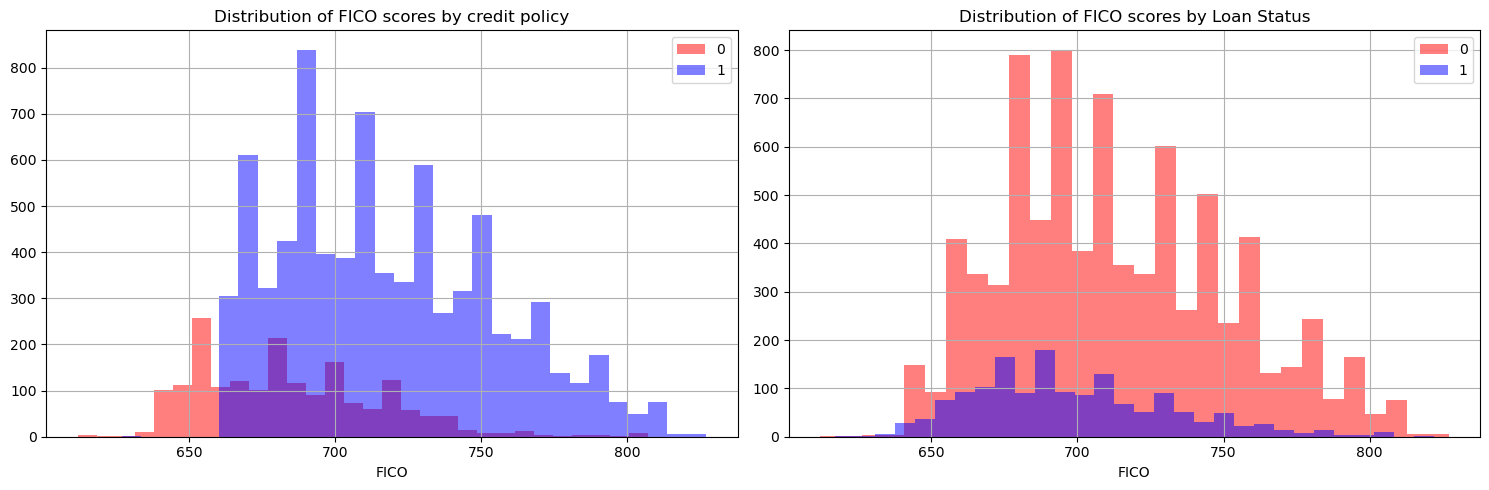

In [5]:
# Set up subplots with 1 row and 2 columns
plt.figure(figsize=(15, 5))

# Common color for both histograms
color = 'blue'

# Plot the first histogram
plt.subplot(1, 2, 1)
df[df['credit.policy']==0]['fico'].hist(bins=30, alpha=0.5, label='0', color='red')
df[df['credit.policy']==1]['fico'].hist(bins=30, alpha=0.5, label='1', color=color)
plt.legend()
plt.xlabel('FICO')
plt.title('Distribution of FICO scores by credit policy')

# Plot the first histogram
plt.subplot(1, 2, 2)
df[df['not.fully.paid']==0]['fico'].hist(bins=30, alpha=0.5, label='0', color='red')
df[df['not.fully.paid']==1]['fico'].hist(bins=30, alpha=0.5, label='1', color=color)
plt.legend()
plt.xlabel('FICO')
plt.title('Distribution of FICO scores by Loan Status')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()




Now, let's also have a look at the distribution of FICO scores, interest rates charged and how they relate to each other. 

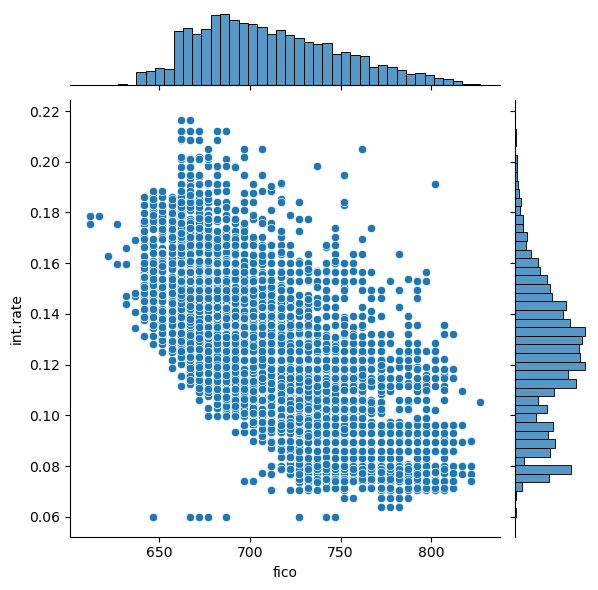

In [6]:
sns.jointplot(x='fico',y='int.rate',data=df)

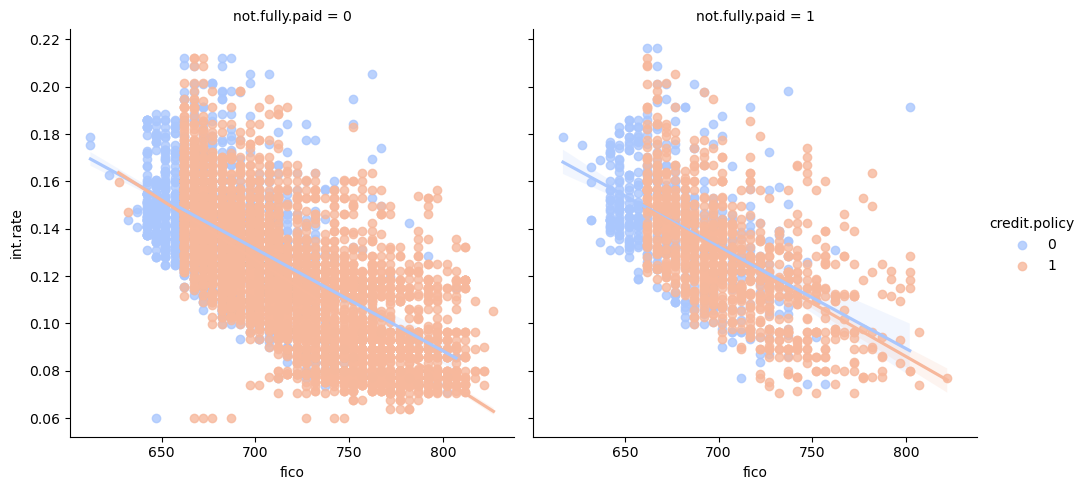

In [7]:
sns.lmplot(x='fico',y='int.rate',data=df,col='not.fully.paid',hue='credit.policy',palette='coolwarm')

Given a FICO score, there seems to be greater dispersion, in terms of interest rates charges, of borrowers that haven't paid their loan back fully and therefore may default. This is a reminder that other variables should also be taken into account when considering delinquency likelihoods. Before we start processing the data and building our ML model, let's look at the correlation amongst the variables. 

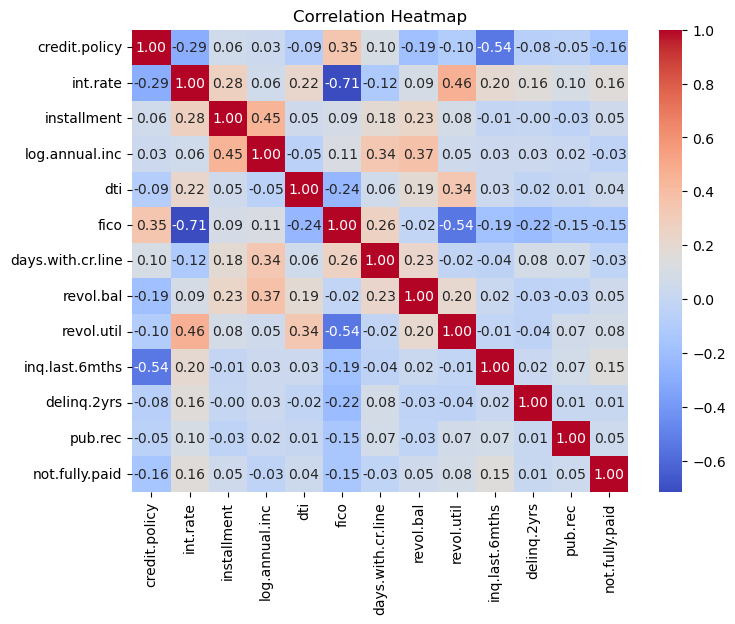

In [8]:
# Select numerical columns from your DataFrame
numerical_columns = df.select_dtypes(include=['number'])
# Create a heatmap of the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(numerical_columns.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

Now convert some categorical variables into dummy variables so that they can be added to the feature set of our ML model. 

In [9]:
df = pd.get_dummies(df,columns=['purpose'],drop_first=True)
df

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_major_purchase,purpose_small_business
0,1,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0,False,True,False,False,False,False
1,1,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0,True,False,False,False,False,False
2,1,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0,False,True,False,False,False,False
3,1,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0,False,True,False,False,False,False
4,1,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9573,0,0.1461,344.76,12.180755,10.39,672,10474.000000,215372,82.1,2,0,0,1,False,False,False,False,False,False
9574,0,0.1253,257.70,11.141862,0.21,722,4380.000000,184,1.1,5,0,0,1,False,False,False,False,False,False
9575,0,0.1071,97.81,10.596635,13.09,687,3450.041667,10036,82.9,8,0,0,1,False,True,False,False,False,False
9576,0,0.1600,351.58,10.819778,19.18,692,1800.000000,0,3.2,5,0,0,1,False,False,False,True,False,False


segregate features from the output which in this case is 'not.fully.paid'. 

In [10]:
X=df.drop('not.fully.paid', axis=1)
y=df['not.fully.paid']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)


## Decision Trees 

Decision Trees are a popular machine learning model used for both classification and regression tasks (though here we use it for classification solely). 
Here is a brief summary of the intuition behind Decision Trees:

1. **Structure**:
- Hierarchical Structure: Decision Trees organize data in a hierarchical manner.
- Nodes: Internal nodes represent decisions based on specific features.

2. **Decision Making**:
- Traversal: The model makes decisions by traversing the tree from the root to a leaf.
- Feature-based Decisions: At each internal node, a decision is made based on a specific feature, leading to a branch.

3. **Splitting Criteria**:
- Objective: The tree learns to split the data by selecting features and thresholds that maximize information gain.

4. **Types**:
- Classification Trees: Leaf nodes represent different classes, and the majority class is assigned to instances in a leaf.
- Regression Trees: Leaf nodes represent numeric values, usually the mean of the target values of instances in that leaf.

5. **Pruning**:
- Overfitting: To prevent overfitting, trees can be pruned by removing branches that do not significantly contribute to predictive performance.

6. **Ensemble Methods**:
- Random Forests and Gradient Boosted Trees: Decision Trees are often used as building blocks in ensemble methods to improve predictive accuracy and robustness.

7. **Interpretability**:
- Visual Decision Process: Decision Trees offer interpretability, making it easy to understand the decision-making process and communicate.

8. **Remarks**:
- Sensitive to Data Distribution: Decision Trees can be sensitive to variations in the training data, leading to different tree structures for slightly different datasets.
- Handling Missing Values: Some implementations can handle missing values during the learning process.

Decision Trees provide a flexible and interpretable approach to machine learning, with the potential for overfitting mitigated through pruning and ensemble methods. Let's use Decision trees to help predict whether a loan is fully paid or not. 


In [11]:
dtree = DecisionTreeClassifier()
dtree.fit(X_train,y_train)
pred = dtree.predict(X_test)

print(classification_report(y_test,pred))
print(confusion_matrix(y_test,pred))

              precision    recall  f1-score   support

           0       0.85      0.84      0.85      2422
           1       0.21      0.23      0.22       452

    accuracy                           0.74      2874
   macro avg       0.53      0.54      0.53      2874
weighted avg       0.75      0.74      0.75      2874

[[2030  392]
 [ 346  106]]


Random forest is a popular supervised machine learning method for classification and regression that consists of using several decision trees, and combining the trees' predictions into an overall prediction. To train the random forest is to train each of its decision trees independently. Each decision tree is typically trained on a slightly different part of the training set, and may look at different features for its node splits. Let's also fit a Random Forest to our data.

In [12]:
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
pred1=rf.predict(X_test)

print(classification_report(y_test,pred1))
print(confusion_matrix(y_test,pred1))

              precision    recall  f1-score   support

           0       0.85      0.99      0.91      2422
           1       0.44      0.03      0.05       452

    accuracy                           0.84      2874
   macro avg       0.64      0.51      0.48      2874
weighted avg       0.78      0.84      0.78      2874

[[2407   15]
 [ 440   12]]


As you see Random Forests take longer to run (even though our dataset is small). They deliver slightly better performance statistics. 

## Exercise 

Tune our random forest by using 'RandomizedSearchCV()' function in sklearn and comment on prediction gains. 

In [13]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(20, 100, num = 5)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf1 = RandomForestClassifier()
rf2 = RandomizedSearchCV(estimator = rf1, param_distributions = random_grid, 
                              cv = 3, verbose=2,n_jobs = -1)
rf2.fit(X_train,y_train)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [20, 40, 60, 80, 100,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000]},
                   verbose=2)

In [18]:
rf2.best_params_


{'n_estimators': 800,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 60,
 'bootstrap': True}

In [15]:
rf3=RandomForestClassifier(n_estimators= 200,
 min_samples_split=2,
 min_samples_leaf=2,
 max_features='auto',
 max_depth=40,
 bootstrap=True)
rf3.fit(X_train,y_train)
preds3=rf3.predict(X_test)

print(classification_report(y_test,preds3))
print(confusion_matrix(y_test,preds3))

c:\Users\Miguel\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


              precision    recall  f1-score   support

           0       0.84      1.00      0.91      2422
           1       0.36      0.01      0.02       452

    accuracy                           0.84      2874
   macro avg       0.60      0.50      0.47      2874
weighted avg       0.77      0.84      0.77      2874

[[2413    9]
 [ 447    5]]


## Support Vector Machines (SVMs)

[SVMs](https://scikit-learn.org/stable/modules/svm.html) are Supervised learning algorithms for classification and regression. They work by finding a hyperplane that best separates data points into different classes while maximizing the margin. Remember that a hyperplane is a decision boundary that separates data points of different classes. The margin is the distance between the hyperplane and the nearest data point from either class. SVMs seek to maximize this margin, promoting better generalization to new, unseen data.

#### Support Vectors:
- **Definition:** Support vectors are the data points that lie closest to the hyperplane and influence its position.
- SVMs are named after these crucial data points as they support the definition of the decision boundary.

### Types:

#### 1. Linear SVM:
- **Hyperplane:** A straight line in 2D, a plane in 3D, and a hyperplane in higher dimensions.
- **Use Case:** Suitable for linearly separable data.

#### 2. Non-Linear SVM (Kernel Trick):
- **Idea:** Transform data into a higher-dimensional space to make it linearly separable.
- **Kernel Functions:** Radial Basis Function (RBF), Polynomial, Sigmoid, etc., are used to achieve non-linear separations.

### The advantages of support vector machines are:

- Effective in high dimensional spaces.
- Still effective in cases where number of dimensions is greater than the number of samples.
- Uses a subset of training points in the decision function (called support vectors), so it is also memory efficient.
- Versatile: different Kernel functions can be specified for the decision function. Common kernels are provided, but it is also possible to specify custom kernels.

### The disadvantages of support vector machines include:
- If the number of features is much greater than the number of samples, avoid over-fitting in choosing Kernel functions and regularization term is crucial.
- SVMs do not directly provide probability estimates, these are calculated using an expensive five-fold cross-validation (see Scores and probabilities, below).



### Commonly used for:
- Image Classification, Text Classification, and Bioinformatics.

### Tips:
- **Normalize Features:** It is often beneficial to normalize input features to ensure equal importance in the model.

Support Vector Machines are powerful and versatile classifiers, effective in scenarios with complex decision boundaries and high-dimensional feature spaces. Let's explore their performance with our loan data.


In [16]:
# Import Support Vector Machine classifier
from sklearn.svm import SVC

# Create a Support Vector Machine classifier
svm_classifier = SVC()

# Train the Support Vector Machine classifier on the training data
svm_classifier.fit(X_train, y_train)

# Make predictions on the test data
svm_pred = svm_classifier.predict(X_test)

# Print the classification report for SVM
print("Support Vector Machine - Classification Report:\n", classification_report(y_test, svm_pred))

# Print the confusion matrix for SVM
print("Support Vector Machine - Confusion Matrix:\n", confusion_matrix(y_test, svm_pred))


Support Vector Machine - Classification Report:
               precision    recall  f1-score   support

           0       0.84      1.00      0.91      2422
           1       0.33      0.00      0.00       452

    accuracy                           0.84      2874
   macro avg       0.59      0.50      0.46      2874
weighted avg       0.76      0.84      0.77      2874

Support Vector Machine - Confusion Matrix:
 [[2420    2]
 [ 451    1]]


## Exercise

Similarly to what you did with Random Forests, Tune the SVM for loan classification. 

In [17]:
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from scipy.stats import uniform
import numpy as np

# Assuming you have already loaded your data into X and y

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

# Create a StandardScaler object
scaler = StandardScaler()

# Fit and transform training data
X_train_standardized = scaler.fit_transform(X_train)

# Transform test data using the same scaler
X_test_standardized = scaler.transform(X_test)

# Define a more compact parameter distribution for random search
param_dist = {
    'C': uniform(0.1, 1),  # Uniform distribution between 0.1 and 1
    'penalty': ['l1', 'l2'],  # Penalty term for LinearSVC
    'dual': [False],  # Dual parameter for LinearSVC
}

# Create a Linear Support Vector Machine classifier
linear_svm_classifier = LinearSVC()

# Use RandomizedSearchCV for a more efficient search
random_search = RandomizedSearchCV(linear_svm_classifier, param_dist, n_iter=20, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)
random_search.fit(X_train_standardized, y_train)

# Get the best hyperparameters
best_params_random = random_search.best_params_
print("Best Hyperparameters (Random Search):", best_params_random)

# Make predictions on the test data using the best model from random search
best_linear_svm_random = random_search.best_estimator_
linear_svm_pred_random = best_linear_svm_random.predict(X_test_standardized)

# Evaluate the performance of the tuned Linear SVM
print("Tuned Linear Support Vector Machine (Random Search) - Classification Report:\n", classification_report(y_test, linear_svm_pred_random))
print("Tuned Linear Support Vector Machine (Random Search) - Confusion Matrix:\n", confusion_matrix(y_test, linear_svm_pred_random))


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Hyperparameters (Random Search): {'C': 1.0872834785177143, 'dual': False, 'penalty': 'l1'}
Tuned Linear Support Vector Machine (Random Search) - Classification Report:
               precision    recall  f1-score   support

           0       0.83      1.00      0.91      2393
           1       0.00      0.00      0.00       481

    accuracy                           0.83      2874
   macro avg       0.42      0.50      0.45      2874
weighted avg       0.69      0.83      0.76      2874

Tuned Linear Support Vector Machine (Random Search) - Confusion Matrix:
 [[2389    4]
 [ 481    0]]


Some notes about the exercise:
* Performing grid-search with a SVM with a nonlinear Kernel is a computationally prohibitive task. 
* Kernelized SVMs require the computation of a distance function between each point in the dataset, which is the dominating cost of $O(n_{features},n^2_{observations})$. 

To make this task feasible, it helps to think about it a bit before writing code:
* Standardizing the features helps a lot because the Kernel requires the storage of the distances putting a burden on memory
* Using `RandomizedSearchCV()` instead of `GridSearchCV()` also helps. 
* Another option is to use `LinearSVC()`.